In [1]:
from __future__ import division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

In [2]:
!wget -O $PUIDATA/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv -nc https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD
!mkdir -p $PUIDATA/Manhattan
!wget -O $PUIDATA/Manhattan/manpluto.zip -nc https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip
!cd $PUIDATA/Manhattan/; unzip -o manpluto.zip
!ls $PUIDATA/Manhattan

!mv nyc_pluto_16v2.zip $PUIDATA/

File ‘/home/cusp/vmr286/PUIdata/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv’ already there; not retrieving.
--2017-12-03 04:00:56--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip
Resolving www1.nyc.gov... 104.106.240.221, 2600:141b:13:292::1500, 2600:141b:13:297::1500
Connecting to www1.nyc.gov|104.106.240.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9857321 (9.4M) [application/zip]
Saving to: “/home/cusp/vmr286/PUIdata/Manhattan/manpluto.zip”

100%[======================================>] 9,857,321   --.-K/s   in 0.1s    

2017-12-03 04:00:56 (71.1 MB/s) - “/home/cusp/vmr286/PUIdata/Manhattan/manpluto.zip” saved [9857321/9857321]

Archive:  manpluto.zip
  inflating: PLUTODD16v2.pdf         
  inflating: MN_Dcp_Mappinglot.dbf   
  inflating: MN_Dcp_Mappinglot.prj   
  inflating: MN_Dcp_Mappinglot.sbn   
  inflating: MN_Dcp_Mappinglot.sbx   
  inflating: MN_Dcp_Mappinglot.shp   
  inflating: M

In [3]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

In [4]:
nrg.columns

Index([u'BBL', u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BIN', u'NTA'],
      dtype=

In [5]:
len(nrg)

16170

In [6]:
# make sure you clean up your data and throw away columns you do not need!
try:
    nrg.drop([u'Co-reported BBL Status', u'BBLs Co-reported',
           u'Reported NYC Building Identificaiton Numbers (BINs)',
           u'Street Number', u'Street Name', u'Borough', u'Postcode',
           u'DOF Benchmarking Submission Status',u'Primary Property Type - Self Selected', u'DOF Number of Buildings','Community Board', u'Council District',
           u'Census Tract', u'BIN', u'NTA'], axis=1, inplace=True)
except ValueError as e:
    print e
    pass
try:
    bsize.drop(['APPBBL', 'APPDate', 'Address',
           'AreaSource', 'AssessLand', 'AssessTot', 'BldgArea', 'BldgClass',
           'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
           'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
           'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
           'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
           'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
           'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
           'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
           'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
           'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
           'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro',
           'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
           'Tract2010', 'Version', 'XCoord', 'YCoord',
           'YearAlter1', 'YearAlter2', 'ZMCode', 'ZipCode',
           'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'ZoneMap',
           'geometry'], axis=1, inplace=True)
except ValueError as e:
    print e
    pass

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## exploratory analysis

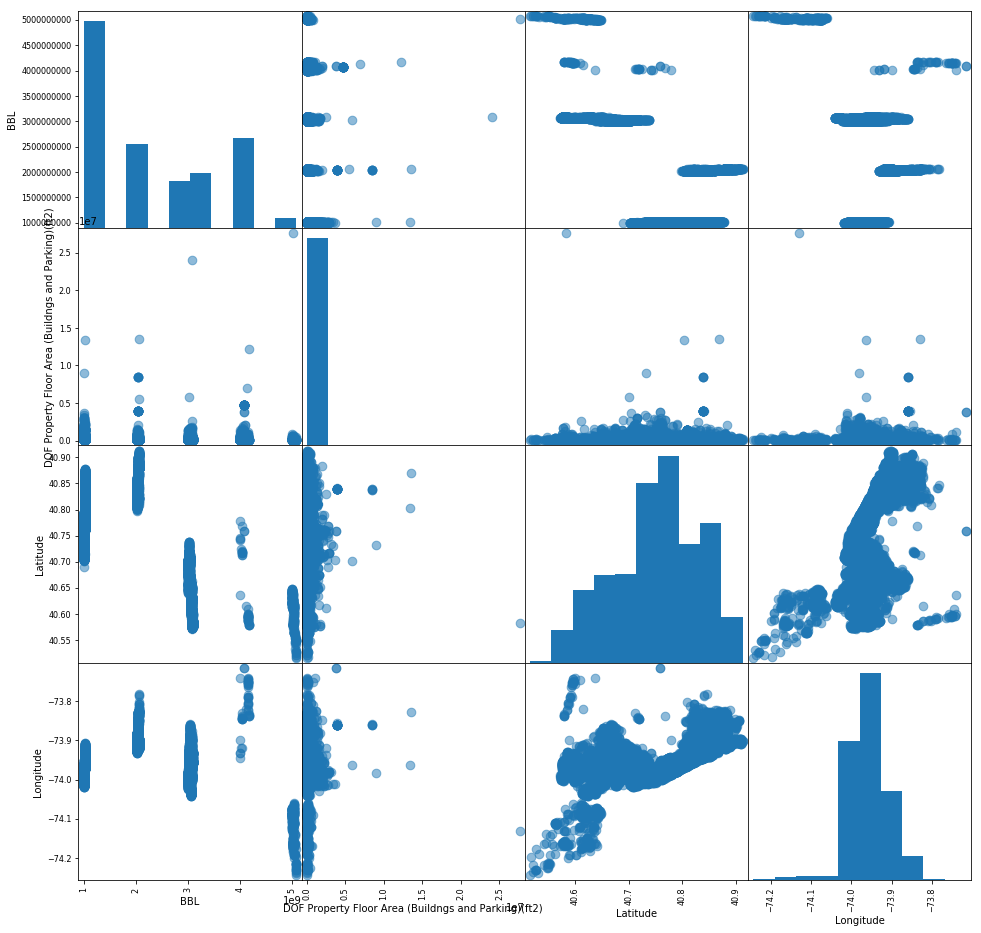

In [7]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones

from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));


Figure 1: scatter matrix of all numerical values in the files. comments on what you see

- Basically the only interesting field here is floor area.
- We see some kind of power distribution going on in the floor area data, so we'll want to take the log of that when we look at it. HOWEVER, this is floor area including parking, and we probably don't care about parking. But I expect the regular floor area distribution to be similar.
- We see a rough map of NYC by way of the lat x long scatter plot. 
- Incidentally we also get some insight into the BBL coding scheme but scatterplots are probably not a good way to look at that.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

In [8]:
# use pd.to_numeric to convert strings to numeric values, 
##check that your conversion worked: e.g.
for column in nrg.columns:
    try:
        if column == 'BBL':
            continue
        nrg[column] = pd.to_numeric(nrg[column], errors='coerce')
        print("worked: {}".format(column))
    except:
        print("broke: {}".format(column))
        continue
        
q = (nrg['Site EUI(kBtu/ft2)'].astype(float))
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
#bsize.BBL.astype(float)
#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


worked: Site EUI(kBtu/ft2)
worked: Weather Normalized Site EUI(kBtu/ft2)
worked: Source EUI(kBtu/ft2)
worked: Weather Normalized Source EUI(kBtu/ft2)
worked: Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)
worked: Automatic Water Benchmarking Eligible
worked: Reported Water Method
worked: ENERGY STAR Score
worked: Total GHG Emissions(MtCO2e)
worked: Direct GHG Emissions(MtCO2e)
worked: Indirect GHG Emissions(MtCO2e)
worked: Reported Property Floor Area (Building(s)) (ft²)
worked: DOF Property Floor Area (Buildngs and Parking)(ft2)
worked: Latitude
worked: Longitude


In [9]:
#drop everything you do not need to lighten the memory load on your machine! this is important!! 
#this file has a lot of columnsm most of them you will not need

print("SEE ABOVE...")

SEE ABOVE...


In [10]:
#How many missing values?
indx = np.isnan(nrg['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 4623


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). You can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data _type_ is the same:printing the columns the content may look the same but your computer wont know it is the same if it is a different data type (e.g. '1' string is not the same as 1 integer'. '1' == 1 returns False)! both have to be integers, both strings, or whatever, but the same, or you will not be able to merge. 

In [11]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010201.0, 1000410001.0)

In [12]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL')
bblnrgdata.head()
bblnrgdata.columns
area = 'Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'
usage_per_area = u'Site EUI(kBtu/ft2)'
units = u'UnitsTotal'
bblnrgdata['nrg'] = bblnrgdata[usage_per_area] * bblnrgdata[area]
bblnrgdata['log_nrg'] = np.log10(bblnrgdata['nrg'])
bblnrgdata['log_units'] = np.log10(bblnrgdata['UnitsTotal'])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:1237: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:941: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.is_unique


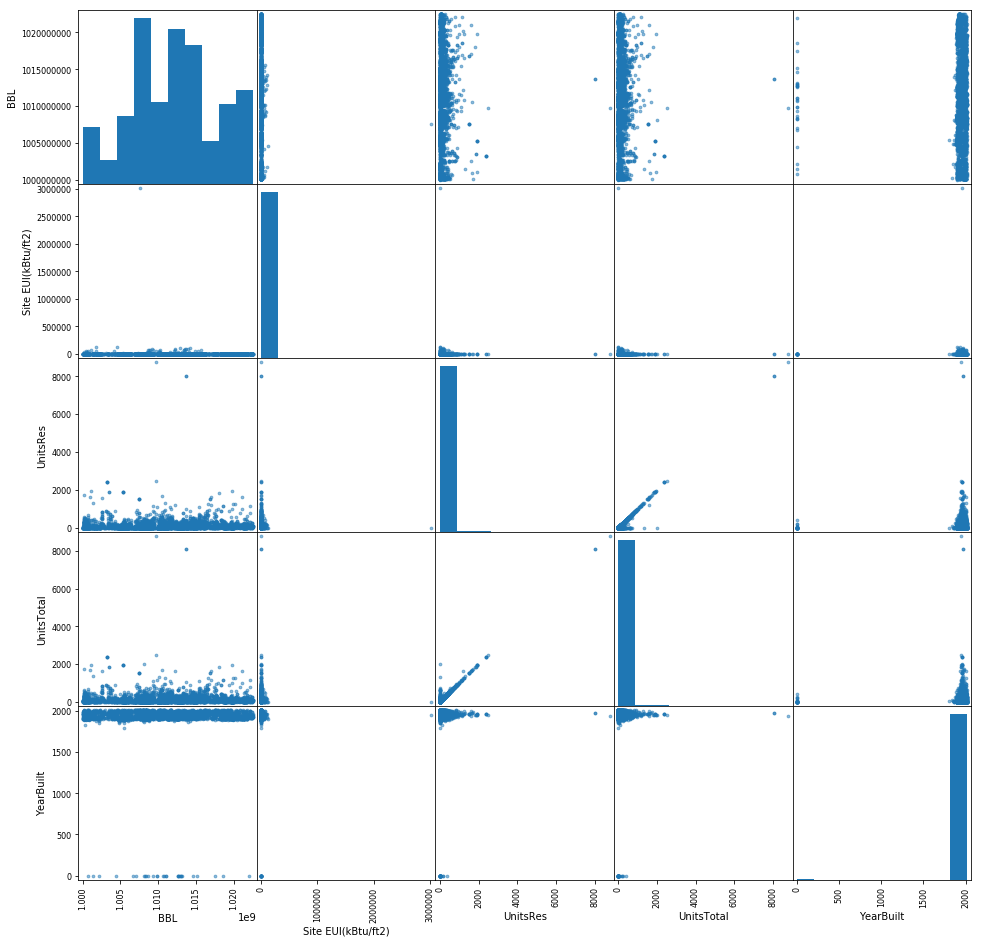

In [13]:
# Now the scatter matrix plot should show more columns.
scatter_matrix(bblnrgdata[[u'BBL',
                           u'Site EUI(kBtu/ft2)',
                           u'UnitsRes',
                           u'UnitsTotal',
                           u'YearBuilt']], s=30, figsize=(16, 16));

Figure 2: scatter matix of final dataset (please describe)
- Lots of power law distributions. We'll need log-log plots.
- Direct linear relationship between residental vs. total units. It won't really matter which we choose.
- EUI vs. Units is going to need log-log, again.
- YearBuilt we need to clean out the 0 values (unless those buildings were built in year 0....)

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

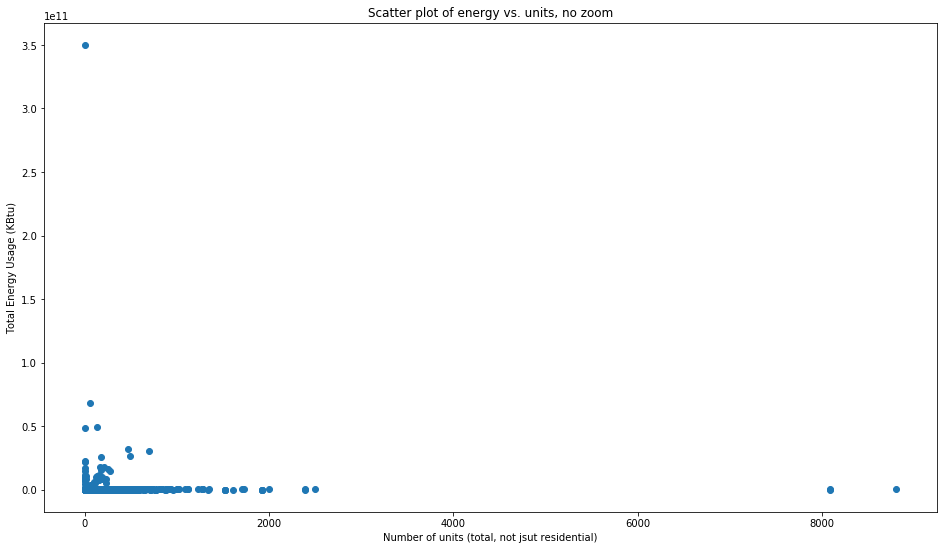

In [14]:
fig = plt.figure(1, figsize=(16, 9))

plt.scatter(bblnrgdata[units], bblnrgdata['nrg'])
plt.title("Scatter plot of energy vs. units, no zoom")
plt.xlabel("Number of units (total, not jsut residential)")
plt.ylabel("Total Energy Usage (KBtu)")

### CAPTION: We really want to log plot this, however, we also need to remove 0 values and filter some of the extraneous data points. Let's zoom in to see more...

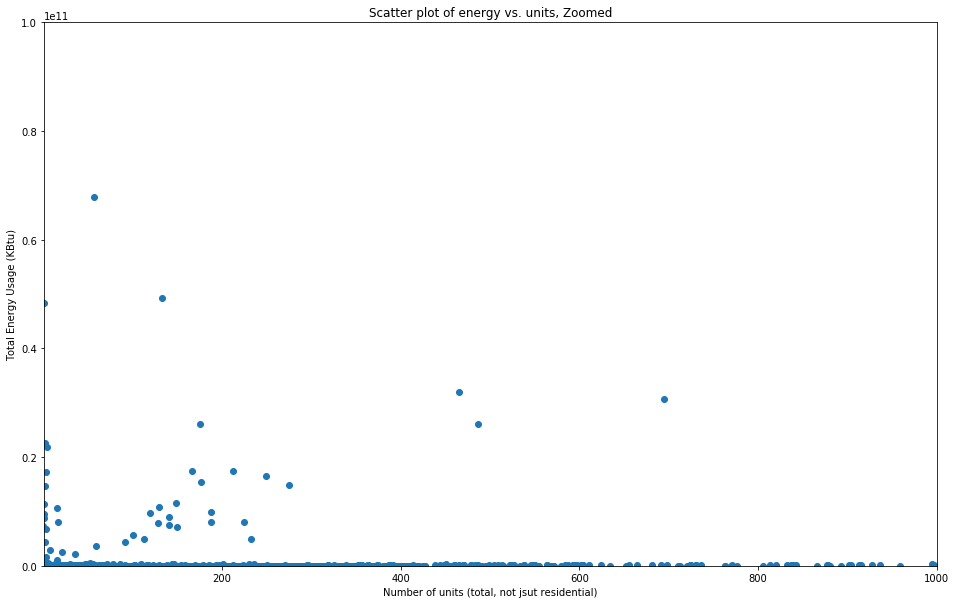

In [15]:
# zoomed in scatter plot
plt.figure(1, figsize=(16, 10))
plt.scatter( bblnrgdata[units], bblnrgdata['nrg'])
plt.xlim(1, 1000)
plt.ylim(0, 1e11)
plt.title("Scatter plot of energy vs. units, Zoomed")
plt.xlabel("Number of units (total, not jsut residential)")
plt.ylabel("Total Energy Usage (KBtu)")

### CAPTION: Still want a log plot here, but we can see a linear trend does exist for certain buildings on a non-log scale (I wonder if they are somehow a separate class of building)

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **
**try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and expand the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. You can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000] - see below.

Also I removed the buildings with several thousand units. Points like that at the edge of my range would have a lot of "LEVERAGE", however they are not spurious entries like the 0, which I believe are missing values, or perhaps abandoned lots. These are good datapoint that I need to throw away functionally for my analysis to work, but that should be stated clearly in your report.


In [16]:
#you may need to change the name of this column under some versions of pandas
#(ft²) may throw an error due to the funny character depending on encoding
bblnrgdata['Reported Property Floor Area'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


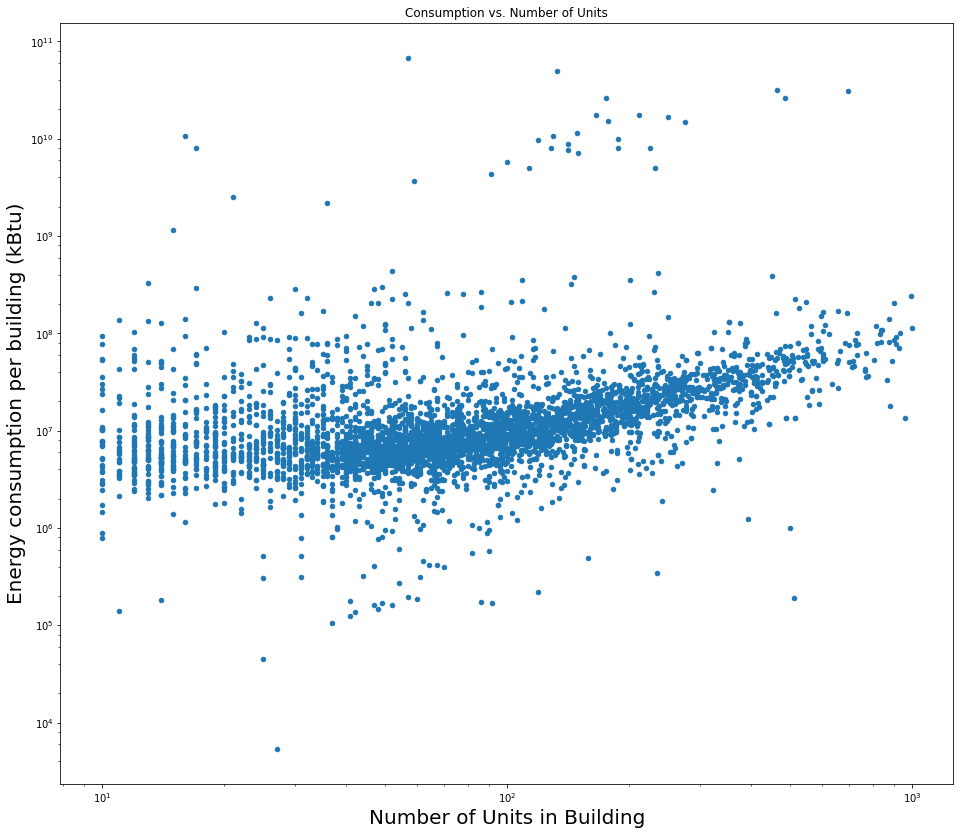

In [17]:
# I have the energy per sq foot in the data, I need the total energy though
# bblnrgdata['nrg'] = ...

bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                           (bblnrgdata.UnitsTotal<1000)]

ax = bblnrgdataCut.plot(kind='scatter', y='nrg', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_title("Consumption vs. Number of Units")

### CAPTION: Now, on this filtered data, we see evidence of a linear relationship between the log energy consumption and the log number of units, which makes sense given the underlying distributions of these two variables that we saw in our histograms + scatter plots above.

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 


### DISCUSSION: Logically speaking, we assume energy consumption depends on size of building (i.e. # of units). We can compare these models with a chi^2 test. 

1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_units   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Sun, 03 Dec 2017   Prob (F-statistic):          2.05e-166
Time:                        04:01:49   Log-Likelihood:                -1746.4
No. Observations:                4266   AIC:                             3497.
Df Residuals:                    4264   BIC:                             3510.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4563      0.082     -5.596      0.000        -0.616    -0.296
log_nrg        0.3328      0.012     28.761      0.000         0.310     0.356
==============================================================================
Omnibus:                      149.498   Durbin-Watson:                   1.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.251
Skew:                          -0.464   Prob(JB):                     1.31e-36
Kurtosis:                       3.260   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

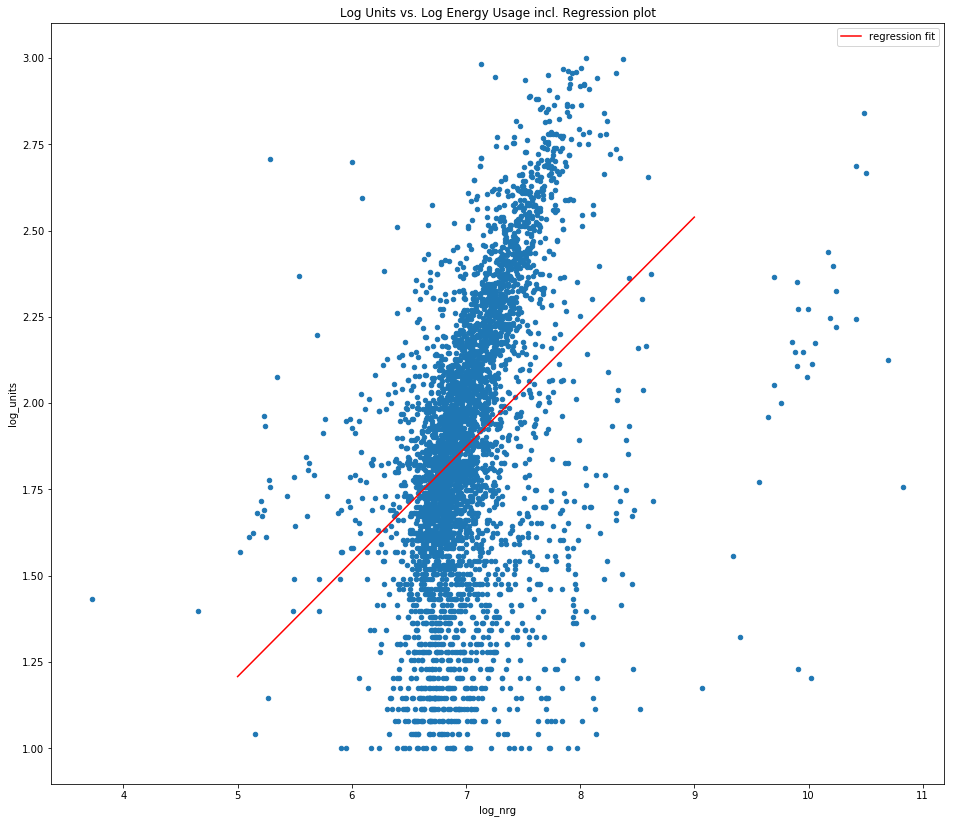

In [18]:
import statsmodels.regression.linear_model as sm

X = sm.add_constant(bblnrgdataCut["log_nrg"])
unitsvsnrg = sm.OLS(bblnrgdataCut["log_units"], X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
b = np.linspace(5, 9, 100)


ax = bblnrgdataCut.plot(kind='scatter', y='log_units', x='log_nrg', 
                        marker='o',  figsize=(16, 14))
ax.plot(b, unitsvsnrg.params[0] + np.dot(b, unitsvsnrg.params[1]), color='r', label='regression fit')
ax.set_title("Log Units vs. Log Energy Usage incl. Regression plot")
ax.legend()
unitsvsnrg.summary()

### CAPTION: This is backwards. Also R^2 (which will be the same either way) is .162, which isn't fantastic.

2. **Fit a line** to Energy vs Units.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Sun, 03 Dec 2017   Prob (F-statistic):          2.05e-166
Time:                        04:01:50   Log-Likelihood:                -2563.5
No. Observations:                4266   AIC:                             5131.
Df Residuals:                    4264   BIC:                             5144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1110      0.033    187.012      0.000         6.047     6.175
UnitsTotal     0.4882      0.017     28.761      0.000         0.455     0.521
==============================================================================
Omnibus:                     2264.923   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44888.937
Skew:                           2.089   Prob(JB):                         0.00
Kurtosis:                      18.333   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

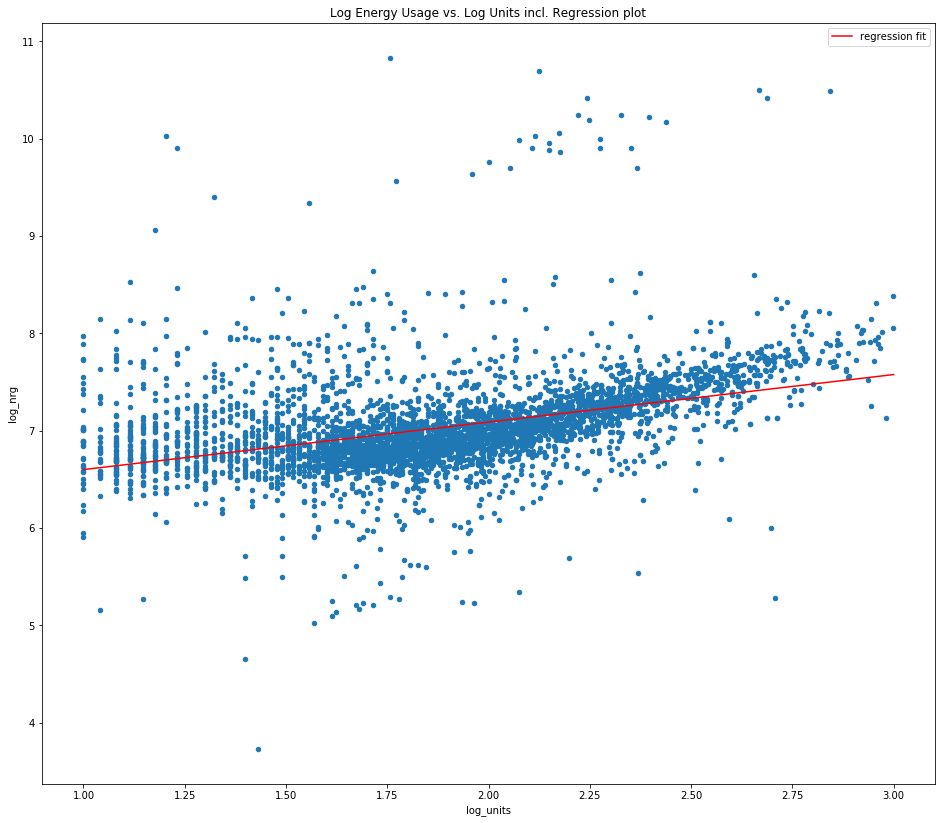

In [19]:
import statsmodels.regression.linear_model as sm
X = sm.add_constant(np.log10(bblnrgdataCut["UnitsTotal"]))
nrgvsunits = sm.OLS(np.log10(bblnrgdataCut["nrg"]), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
b = np.linspace(1, 3, 100)


ax = bblnrgdataCut.plot(kind='scatter', y='log_nrg', x='log_units', 
                        marker='o',  figsize=(16, 14))
ax.plot(b, nrgvsunits.params[0] + np.dot(b, nrgvsunits.params[1]), color='r', label='regression fit')
ax.set_title("Log Energy Usage vs. Log Units incl. Regression plot")
ax.legend()
nrgvsunits.summary()

3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

### Answer - they are not nested and we cannot use the likelihood ratio here, as it's not meaningful.

    The function is :
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value  model($x_i$) is the prediction, data($x_i$) the observation,
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors?? see next point)
    
4. *Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

### Explanation: For nrg, use the quadrature error propogation formula to generate the error after 1) combining two poisson statistics and 2) taking the log of that combination. For units, take the log of the poisson statistic and propogate error appropriately as per the formulas.


In [20]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1



### IMPORTANT NOTE: I took the error propogation formula for the product from [wikipedia](https://en.wikipedia.org/wiki/Propagation_of_uncertainty) (or the [wolfram alpha site](https://reference.wolfram.com/applications/eda/ExperimentalErrorsAndErrorAnalysis.html)), which is why my error numbers are different. However, as it turns out either formula is OK because we simply need something on the same scale for our comparisons (rather than the precisely correct formula). The conclusion with the chi$^2$ test remains the same.

In [21]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
# errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area'])**2 +\
#                 (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

errorsnrg = bblnrgdataCut['nrg'] * np.sqrt(\
(np.sqrt(bblnrgdataCut['Reported Property Floor Area']) / bblnrgdataCut['Reported Property Floor Area'])**2  +\
(np.sqrt(bblnrgdataCut['Site EUI(kBtu/ft2)']) / bblnrgdataCut['Site EUI(kBtu/ft2)']) ** 2)
## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#These errors need to be propagated properly through the log


errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

nrgvsunitschi2 = chi2(bblnrgdataCut['log_nrg'], nrgvsunits.predict(), bblnrgdataCut['errorsnrg'])
unitsvsnrgchi2 = chi2(bblnrgdataCut['log_units'], unitsvsnrg.predict(), bblnrgdataCut['errorsunits'])
ndof = float(len(bblnrgdataCut) - 2) # same for both models
print "Units vs. Energy usage: {}".format(unitsvsnrgchi2)
print "Energy usage vs. Units: {}".format(nrgvsunitschi2)
print "Units vs. Energy usage (reduced): {}".format(unitsvsnrgchi2 / ndof)
print "Energy usage vs. Units (reduced): {}".format(nrgvsunitschi2 / ndof)

Units vs. Energy usage: 485793.290042
Energy usage vs. Units: 53297921.8942
Units vs. Energy usage (reduced): 113.929007984
Energy usage vs. Units (reduced): 12499.5126394


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Conclusion: from the above values, log units vs. log energy actually has a lower chi-squared value, which implies that it may be the better fit when we also account for errors in the data. This may be a function of the fact that log units has smaller numbers and therefore smaller error values.

    

5. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

Intercept         -4.415582
I(log_nrg ** 2)   -0.072008
log_nrg            1.404603
dtype: float64

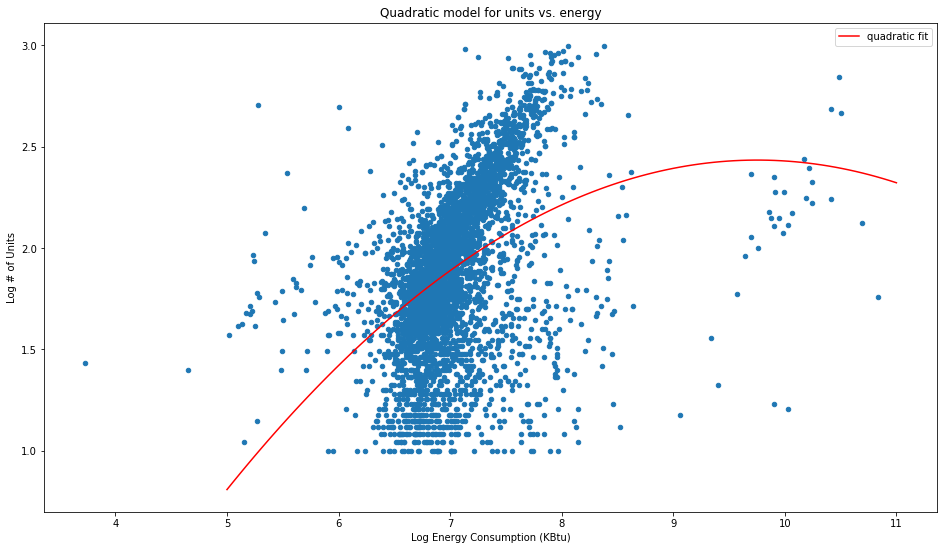

In [22]:
import statsmodels.formula.api
quad_model = statsmodels.formula.api.ols("log_units ~ I(log_nrg**2) + log_nrg",bblnrgdataCut ).fit()
ax = bblnrgdataCut.plot("log_nrg", "log_units", kind="scatter", figsize=(16, 9))
x = np.linspace(5, 11, 100)
y = quad_model.params[0] + quad_model.params[2] * x + quad_model.params[1] * (x ** 2)
ax.plot(x, y, 'r-', label='quadratic fit')
ax.legend()
ax.set_title("Quadratic model for units vs. energy")
ax.set_xlabel("Log Energy Consumption (KBtu)")
ax.set_ylabel("Log # of Units")
quad_model.summary()
quad_model.params

6. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * log(Likelihood_Model1 / Likelihood_Model2) 

    or equivalently
        
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2) 
    
    where Model1 is the _least complex_ (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels. (Model1.llf)
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferable to Model2. The LR is chi^2 distributed with number of degrees of freedom $N_{DOF}$ = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))

In [23]:
linemodel = unitsvsnrg
curvemodel = quad_model
print ("LR : ", 2 * (-linemodel.llf - (-curvemodel.llf)))

('LR : ', 99.244236570108114)


With 1 degree of freedom, at 99.244, we are at a very low p-value at this point (significantly < .005) . Thus we can reject the null hypothesis and say the quadratic fit is better than the linear fit. Statsmodels verifies and shows the exact p-value below.

In [24]:
print curvemodel.compare_lr_test(linemodel)

(99.244236570108114, 2.2320522718556195e-23, 1.0)


## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

In [25]:
B = np.arange(-100, 100, 1)
A = np.arange(-50, 50, .5)

# take every combination of a \in A * x
predictions = np.outer(A, np.log(bblnrgdataCut.UnitsTotal))
Lsurface = np.zeros((len(A), len(B)))

for j, b in enumerate(B):
    preds_with_b = (predictions + b) 
    squared_errors = (preds_with_b - np.log(bblnrgdataCut.nrg).reshape(1, -1))**2
    adj_squared_errors = squared_errors / (errorsInLogNrg.reshape(1, -1) ** 2)
    Lsurface[:, j] = np.sum( adj_squared_errors ,axis=1)
    
# compare manually doing A[-1] x B[-1] with the last element of the last result 
# (so A[-1], B[-1])
# from our for loop
final_a_b =  adj_squared_errors.sum(axis=1)[-1]
reference_a_b = chi2(A[-1] *np.log(bblnrgdataCut.UnitsTotal) +  B[-1], 
                     np.log(bblnrgdataCut.nrg), 
                     errorsInLogNrg)
assert final_a_b == reference_a_b

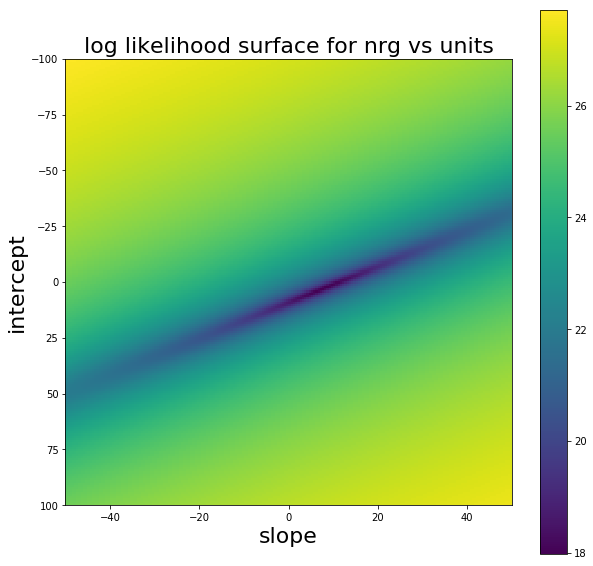

In [26]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface for nrg vs units", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


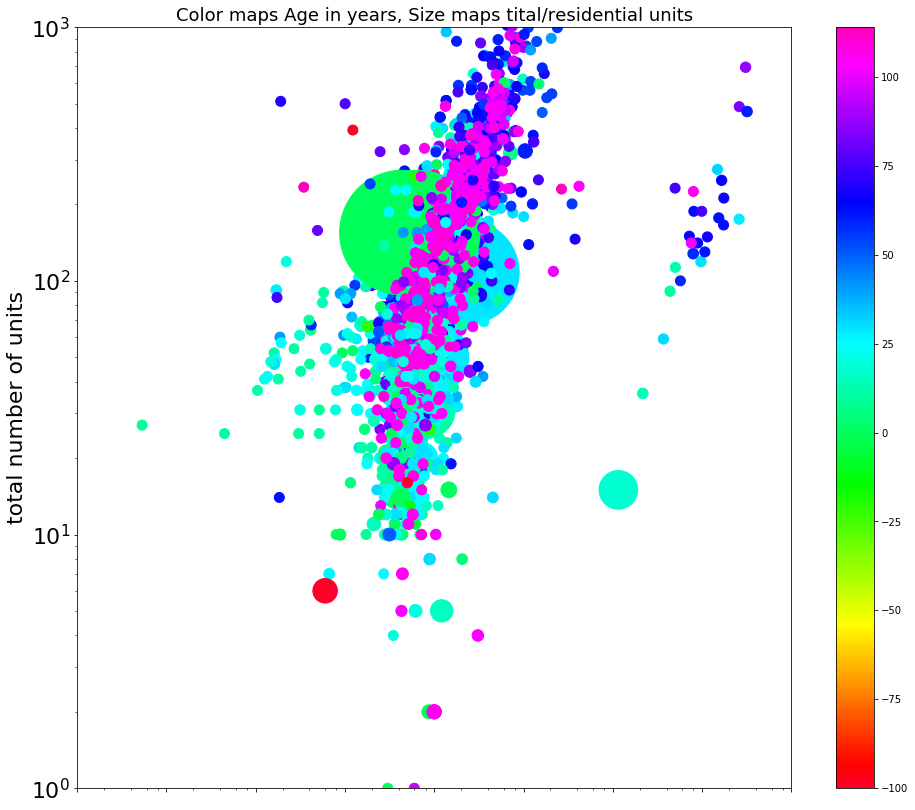

In [27]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)

GRade: 10/10